# Product Grouping Analysis
## Summary
## 1. Initialize Notebook
This section initializes the necessary packages and defines auxiliary functions.

### 1.1 Notebook Settings

In [1]:

## set transformer model 
#py_model_name = 'all-MiniLM-L6-v2' # primarily English
#py_model_name = 'paraphrase-multilingual-MiniLM-L12-v2' # multilingual
py_model_name = 'LaBSE' 
#py_model_name = 'xlm-r-100langs-bert-base-nli-stsb-mean-tokens' 

# runner ups to try, according to ChatGPT:
# - XLM-RoBERTa
# - mBART-50
# - MT5 (Multilingual T5)
# - ByT5 (handles raw text at the byte level, ideal for multilingual similarity tasks).
# - mLUKE (multilingual version of LUKE, good for named entity recognition and contextual understanding).
# - mBERT (baseline multilingual BERT, effective but less performant than XLM-R).

n_cores = 8


### 1.2 Load Packages

In [ ]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["SIM_EMBEDDINGS_CORES"] = f"{n_cores}"

import pandas as pd
import polars as pl

import random
import pickle
import numpy as np
from tqdm import tqdm
import sentence_transformers as st

import nltk
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import multiprocessing
multiprocessing.set_start_method("forkserver", force=True)

import torch
torch.set_num_threads(n_cores)

from plotnine import *


### 1.3 Globally Used Code

In [3]:
# Enable the underscore notation for polars columns, similar to ibis and dplyr (i.e., `pl.col("column_name")` -> `_.column_name`)
class PolarsColumnNamespace:
    def __getattr__(self, name):
        return pl.col(name)

# Enable _ as a shorthand for that class
_ = PolarsColumnNamespace()

## 2. Prepare Transactional Data
### 2.1 Read Transactional Data
mention that these are two datasets from UCI

In [4]:
df1 = pl.read_excel('./data/online+retail/Online Retail.xlsx')
df2 = pl.read_excel('./data/online+retail+ii/online_retail_II.xlsx')
df2 = df2.rename({"Invoice": "InvoiceNo","Price": "UnitPrice", "Customer ID": "CustomerID"})
df = df1.vstack(df2)

### 2.2 Clean Up Dataset
#### 2.2.1 Missing Invoice IDs
- A number of records do not have an invoice id. We'll exclude them, because we cannot use them to determine the basket co-occurrence frequencies for the respective entries.
- This applies to $19500$ rows, i.e., $1.8\%$ of the records

In [5]:
nrows_null = df.filter( _.InvoiceNo.is_null() ).shape[0]
nrows_total = df.shape[0]
(nrows_null, nrows_null / nrows_total)

(19500, 0.018269203743781444)

In [6]:
# drop rows with null InvoiceNo
df = df.filter( ~_.InvoiceNo.is_null() )

### 2.2.2 Missing or Incorrect Product Descriptions
- Some product descriptions indicate adjustments or comments rather than product names. In some cases, additional information is provided, and in others, they have been initially mislabeled.
- We'll exclude the corresponding transactions from the data.
- Exploratory analysis showed that nearly all proper product descriptions are uppercase, and those that are not fully uppercase are in title case.
    - Thus, one heuristic to identify anomalous descriptions is calculating the relative number of uppercase letters at the start of a word.

In [7]:
df = ( df
    .with_columns([
        # Extract the count of lowercase letters starting a word and store it in a new column
        _.Description.str.extract_all(r"[^A-Za-z][a-z]").list.len().alias("lowercase_start_count"),
        # Extract the count of uppercase letters starting a word and store it in a new column
        _.Description.str.extract_all(r"[^A-Za-z][A-Z]").list.len().alias("uppercase_start_count")
    ])
    .with_columns([
        # Create a boolean column indicating if there are no letters starting a word
        ( (_.lowercase_start_count == 0) & (_.uppercase_start_count == 0) ).alias("no_letter_start"),
        # Create a boolean column indicating if there are more lowercase letters starting words than uppercase
        (  _.lowercase_start_count > _.uppercase_start_count ).alias("largely_lowercase_start")
    ])
    .with_columns([
        # Create a final boolean column indicating if the description is anomalous
        ( _.largely_lowercase_start | _.no_letter_start | _.Description.is_null() ).alias("is_anomalous_description")
    ])
    # Drop the intermediate columns used for calculations
    .drop(["lowercase_start_count", "uppercase_start_count", "no_letter_start", "largely_lowercase_start"])
)

In [8]:
#  Verify that all descriptions classified as anomalous are so indeed
print(df.filter(_.is_anomalous_description)["Description"].unique().to_list())

[None, 'Dotcom set', 'amazon adjust', 'checked', '17129c', 'wet cartons', 'sold as gold', 'OOPS ! adjustment', 'Dotcom', 'CHECK', 'rust,missing sets etc', 'incorrectly credited C550456 see 47', 'Breakages', 'lost??', '???lost', 'tk maxx mix up with pink', 'thrown away', 'missing?', 'Unsaleable, destroyed.', 'my error - connor', 'Wrongly mrked had 85123a in box', 'amendment', 'FBA', 'wrongly coded-23343', 'missing (wrongly coded?)', 'test', 'for show', 'damages etc', 'debenhams', 'check', 'mixed up', 'Thrown away-rusty', '??', 'missings', 'historic computer difference?....se', 'amazon', 'wonky bottom/broken', 'Adjustment by john on 26/01/2010 16', 'sold in wrong qnty', 'sold as 1', 'show', 'SOMBRERO ', 'wrong invc', 'broken', 'dotcom sales', 'This is a test product.', 'rcvd be air temp fix for dotcom sit', 'mystery! Only ever imported 1800', '?', 'counted', 'Damaged', '22719', 'cracked', 'did  a credit  and did not tick ret', 'dotcom', '? sold as sets?', 'wet?', 'dotcom adjust', '????mi

In [9]:
# Check all the remaining product descriptions
print(df.filter(~_.is_anomalous_description)["Description"].unique().to_list())

['STAR WOODEN CHRISTMAS DECORATION', 'ENAMEL DINNER PLATE PANTRY', 'TOAST ITS - I LOVE YOU ', 'SET OF 4 NAPKIN CHARMS CUTLERY', 'TEA TIME CAKE STAND IN GIFT BOX', 'WOODLAND  STICKERS', 'WALL TIDY RETROSPOT ', 'SMALL ZINC/GLASS CANDLEHOLDER', 'YELLOW/BLUE RETRO RADIO', 'EMBROIDERED RIBBON REEL CLAIRE', 'SKULLS SQUARE TISSUE BOX', 'GREEN BLUE FLOWER PIGGY BANK', 'PINK LOVE HEART SHAPE CUP', 'COLUMBIAN  CUBE CANDLE ', 'ZINC T-LIGHT HOLDER STARS SMALL', 'SMALL IVORY HEART WALL ORGANISER', 'MOROCCAN BEATEN METAL DISH LARGE', 'BLACK RETRODISC LAMPSHADE', 'MINI CAKE STAND WITH HANGING CAKES', '6 GIFT TAGS VINTAGE CHRISTMAS ', 'METAL MEDINA LANTERN ', 'TEA FOR ONE POLKADOT', 'WHITE STONE/CRYSTAL EARRINGS', 'DOLLY HONEYCOMB GARLAND', 'WRAP FOLK ART', 'FAIRY TALE COTTAGE NIGHTLIGHT', 'LUNCHBOX WITH CUTLERY RETROSPOT ', 'STRAWBERRY FAIRY CAKE TEAPOT', 'IVORY ROSE LAMPSHADE ', 'VICTORIAN SEWING BOX MEDIUM', 'NUMBER TILE COTTAGE GARDEN, 4', 'GREEN ROSE WASHBAG', 'BLOSSOM IMAGES GIFT WRAP SET', 'BLA

- This applies to 4193 rows, i.e., $0.4\%$ of the records

In [10]:
nrows_anomalous_description = df.filter(_.is_anomalous_description).shape[0]
nrows_total = df.shape[0]
(nrows_anomalous_description, nrows_anomalous_description / nrows_total)

(8575, 0.0081832670083121)

In [11]:
# Extract the transaction IDs associated with anomalous descriptions
anomalous_transactions = df.filter(_.is_anomalous_description).select(_.InvoiceNo).with_columns([pl.lit(True).alias("is_anomalous_invoice")])

df = (df
    # Join the main dataframe with the anomalous transactions to mark them
    .join(anomalous_transactions, on="InvoiceNo", how="left")
    # Filter out the rows where the invoice is marked as anomalous
    .filter(_.is_anomalous_invoice.is_null())
    # Drop the columns used for marking and filtering
    .drop(["is_anomalous_description", "is_anomalous_invoice"])
)

### 2.3 Separate Transaction and Product Information
- Here, we separate the transaction and product information

In [12]:
transactions_df = df.select(_.InvoiceNo, _.StockCode)
products_df = df.select(_.StockCode, _.Description).unique()

## 3. Product Description Embeddings
### 3.1 Create Unique Product Descriptions

In [13]:
# Group by StockCode and count the occurrences, then sort by count in descending order and get the list of StockCodes
stock_codes = (products_df
    .group_by(_.StockCode)
    .count()
    .sort(_.count, descending=True)
)["StockCode"].to_list()

# Create a pivot table with StockCode as the index and Description as the values
unique_product_descriptions = (products_df
    # Add a row index for each StockCode
    .with_columns( pl.arange(0, pl.count()).over("StockCode").alias("row_idx"))
    .pivot( values="Description", index="row_idx", on="StockCode", aggregate_function="first")
)[stock_codes]

/tmp/ipykernel_73887/2875576161.py:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/tmp/ipykernel_73887/2875576161.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .with_columns( pl.arange(0, pl.count()).over("StockCode").alias("row_idx"))


In [14]:
# Display the pivot table
unique_product_descriptions

20685,22344,21955,23196,22384,22346,22345,23236,23396,84997b,22845,84997A,22952,17107D,21523,84997c,84509c,23413,22356,23209,84509C,84997a,23366,23535,22740,22333,22950,22416,22937,22844,22852,85099B,22785,22200,23231,22191,23370,…,22327,21675,37475,90167,85050,79066k,84529C,84292B,84510E,46000R,23155,23123,85119,23227,85183A,23001,21174,21542,85049c,85231E,23507,82580,72083A,22913,20671,84965A,90058A,23531,90209A,22413,90083,21431,84926D,90016B,22048,22125,22476
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""DOORMAT RED RETROSPOT""","""PARTY PIZZA DISH PINK POLKADOT""","""UNION JACK GUNS & ROSES DOORM…","""LEAVES MAGNETIC SHOPPING LIST""","""LUNCHBAG PINK RETROSPOT""","""PARTY PIZZA DISH GREEN WHITE S…","""PARTY PIZZA DISH BLUE+WHITE SP…","""DOILEY BISCUIT TIN""","""LE JARDIN BOTANIQUE CUSHION CO…","""CHILDRENS CUTLERY RETROSPOT RE…","""VINTAGE CAT FOOD CONTAINER""","""GREEN 3 PIECE MINI DOTS CUTLER…","""60 CAKE CASES VINTAGE CHRISTMA…","""FLOWER FAIRY 5 SUMMER DRAW LIN…","""FANCY FONT HOME SWEET HOME DOO…","""BLUE 3 PIECE POLKADOT CUTLERY …","""SET OF 4 DOTTY PLACEMATS ""","""VINTAGE COFFEE GRINDER BOX""","""CHARLOTTE BAG , PINK/WHITE SPO…","""LUNCH BAG VINTAGE DOILEY ""","""SET OF 4 POLKADOT PLACEMATS ""","""CHILDRENS CUTLERY POLKADOT GRE…","""SET 12 COLOUR PENCILS DOILEY""","""WALL ART BICYCLE SAFETY""","""POLKADOT PEN""","""RETRO SPOT PARTY BAG + STICKER…","""36 DOILIES VINTAGE CHRISTMAS""","""SET OF 36 SPACEBOY PAPER DOILI…","""BAKING MOULD CHOCOLATE CUP CAK…","""VINTAGE DOG FOOD CONTAINER""","""DOG BOWL, ENAMEL , CREAM COLOU…","""JUMBO BAG RED RETROSPOT""","""SQUARECUSHION COVER PINK UNION…","""FRYING PAN PINK POLKADOT ""","""WRAP DOILEY DESIGN""","""IVORY DINER WALL CLOCK""","""SET 36 COLOUR PENCILS DOILEY""",…,"""ROUND SNACK BOXES SET OF 4 SKU…","""BUTTERFLIES STICKERS""","""SET/4 COLOURFUL MIXING BOWLS""","""BEADED LOVE HEART JEWELLERY SE…","""FRENCH ENAMEL SOAP DISH WITH L…","""RETRO MOD TRAY""","""YELLOW KNITTED KIDS RUCKSACK""","""BLUE COL METAL FOLDING CHAIR""","""SET OF 4 GREEN CAROUSEL COASTE…","""POLYESTER FILLER PAD 45x30cm""","""KNICKERBOCKERGLORY MAGNET ASSO…","""COCKTAIL SWORDS 50 PIECES""","""WATERING CAN SINGLE HOOK PISTA…","""FILIGREE HEART BUTTERFLY WHITE…","""CHARLIE & LOLA WASTEPAPER BIN …","""TRAVEL CARD WALLET DOTCOMGIFTS…","""POTTERING IN THE SHED METAL SI…","""WOODLAND WATER TRANSFER TATTOO…","""ROMANTIC PINKS RIBBONS ""","""STRAWBERRY SCENTED SET/9 T-LIG…","""MINI PLAYING CARDS BUFFALO BIL…","""BATHROOM METAL SIGN""","""STRAWBERY SWIRL FLARE CANDLE""","""RED COAT RACK PARIS FASHION""","""BLUE TEATIME PRINT BOWL ""","""PINK KASHMIRI COFFEE TABLE ""","""CRYSTAL STUD EARRINGS CLEAR DI…","""WALL ART BIG LOVE ""","""PURPLE ENAMEL+GLASS HAIR COMB""","""METAL SIGN TAKE IT OR LEAVE IT…","""CRYSTAL CZECH CROSS PHONE CHAR…","""GREEN GINGHAM FLOWER JEWELLERY…","""LA PALMIERA TILE COASTER""","""GOLD/M.O.P PENDANT ORBIT NECKL…","""BIRTHDAY BANQUET GIFT WRAP""","""UNION JACK HOT WATER BOTTLE ""","""EMPIRE UNION JACK TV DINNER TR…"
"""RED SPOTTY COIR DOORMAT""","""PARTY PIZZA DISH PINK WHITE SP…",""" DOORMAT UNION JACK GUNS AND …","""RETRO LEAVES MAGNETIC NOTEPAD""","""LUNCH BAG PINK RETROSPOT""","""PARTY PIZZA DISH GREEN POLKADO…","""PARTY PIZZA DISH BLUE RETROSPO…","""STORAGE TIN VINTAGE DOILEY ""","""LA JARDIN BOTANIQUE CUSHION CO…","""RED 3 PIECE MINI DOTS CUTLERY …","""CAT FOOD CONTAINER , VINTAGE""","""GREEN 3 PIECE POLKADOT CUTLERY…","""72 CAKE CASES VINTAGE CHRISTMA…","""FLOWER FAIRY,5 SUMMER B'DRAW L…","""DOORMAT FANCY FONT HOME SWEET …","""CHILDRENS CUTLERY POLKADOT BLU…","""DOTTY PLACEMATS ""","""DECROTIVEVINTAGE COFFEE GRINDE…","""CHARLOTTE BAG PINK POLKADOT""","""LUNCH BAG DOILEY PATTERN ""","""SET OF 4 DOTTY PLACEMATS ""","""GREEN 3 PIECE MINI DOT

In [15]:
product_descriptions = products_df.group_by("StockCode").agg(
    pl.col("Description").str.concat(" / ").alias("Description")
)

In [16]:
product_descriptions

StockCode,Description
str,str
"""21076""","""SET/20 COLLAGE PAPER NAPKIN """
"""21864""","""UNION JACK FLAG PASSPORT COVER…"
"""22784""","""LANTERN CREAM GAZEBO """
"""23287""","""RED VINTAGE SPOT BEAKER"""
"""22327""","""ROUND SNACK BOXES SET OF 4 SKU…"
…,…
"""22896""","""PEG BAG APPLES DESIGN / PEG BA…"
"""84509C""","""SET OF 4 POLKADOT PLACEMATS /…"
"""84989A""","""75 GREEN FAIRY CAKE CASES"""


### 3.2 Create Description Embeddings


In [17]:
def encode_semantic_embeddings(ids, desc=None, prompt = None, fname_cache = None):
  """ """
  if not desc is None:
    desc = ids

  if (not fname_cache is None) and os.path.exists(fname_cache):
      embeddings = None
      with open(fname_cache, "rb") as f:
        embeddings = pickle.load(f)
      return embeddings

  py_model = st.SentenceTransformer(py_model_name)
  
  embeddings = py_model.encode(
      sentences = desc, 
      prompt = prompt,
      show_progress_bar = True,
      use_multiprocessing=True
      #normalize_embeddings = True # note: apparently dot products can be used instead of cosine sim, if normalized
  )

  if (not fname_cache is None):
      with open(fname_cache, "wb") as f:
          pickle.dump(embeddings, f)

  return embeddings

In [18]:
fname_dkt_embeddings = "./analysis1_embeddings_semantic.pkl"
product_ids = product_descriptions["StockCode"].to_list()
description = product_descriptions["Description"].to_list()
embeddings_semantic = encode_semantic_embeddings(ids = product_ids, desc = description, fname_cache = fname_dkt_embeddings)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

## 4. Fused Embeddings


In [24]:
def normalize_embeddings(embeddings):
  """ """
  return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

In [25]:
norm_embeddings_semantic = normalize_embeddings(embeddings_semantic)
#norm_embeddings_transactional = normalize_embeddings(embeddings_transactional)
#embeddings = np.column_stack((norm_embeddings_semantic, norm_embeddings_transactional))
embeddings = norm_embeddings_semantic
embeddings.shape

(4896, 768)

In [32]:
n_pca_components = embeddings.shape[1]
pca = PCA(n_components=n_pca_components)
embeddings_pca = pca.fit_transform(embeddings)

/home/pavel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


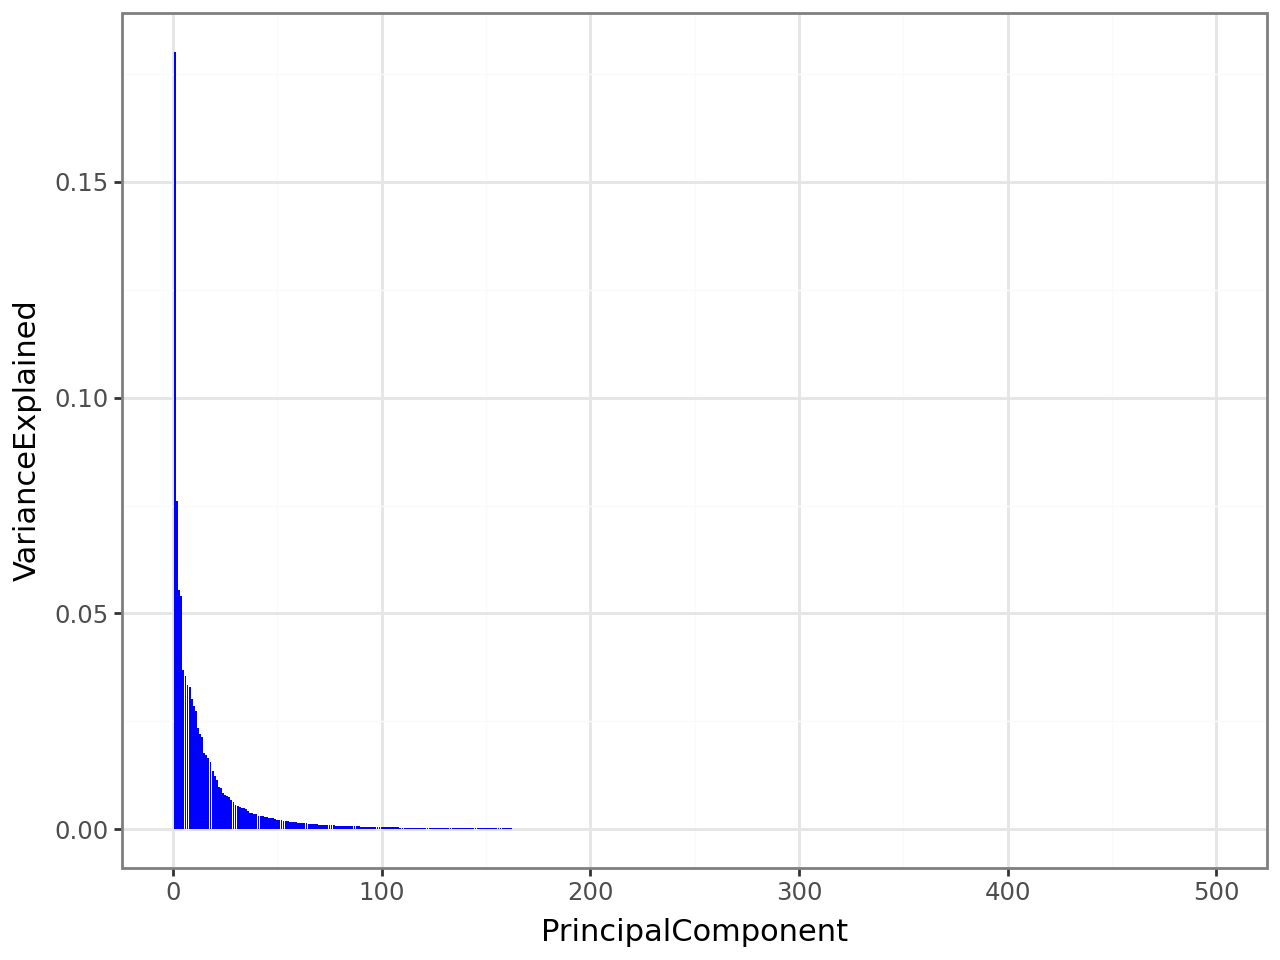

In [ ]:
n_components = n_pca_components
plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'VarianceExplained': pca.explained_variance_ratio_[:(n_components-1)]})
ggplot(plot_df, aes(x="PrincipalComponent", y="VarianceExplained")) + geom_bar(stat = "identity", fill = "blue") + theme_bw()

/home/pavel/.local/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 48 rows containing missing values.


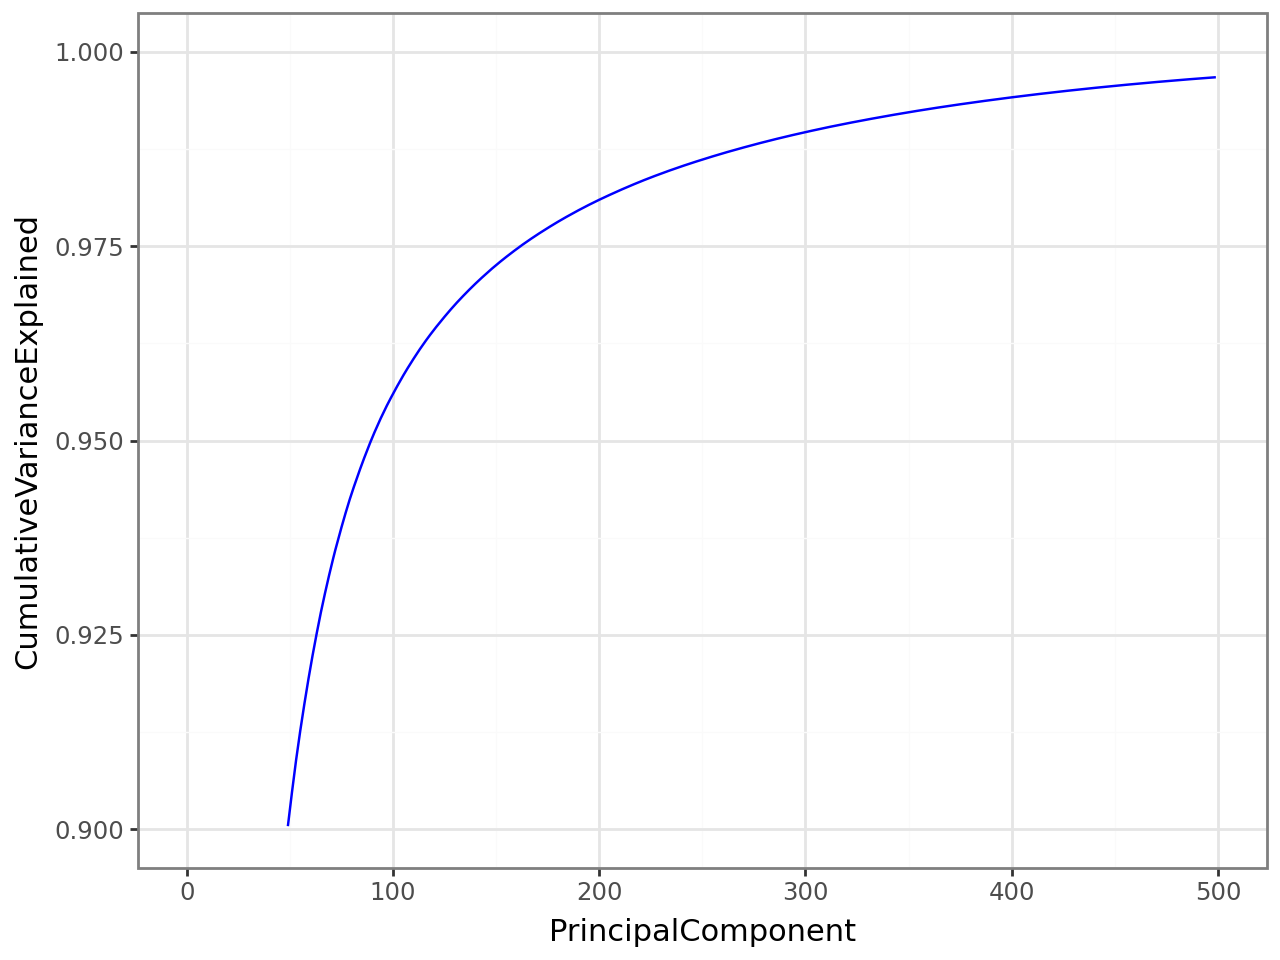

In [30]:
plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'CumulativeVarianceExplained': np.cumsum(pca.explained_variance_ratio_[:(n_components-1)]) })
ggplot(plot_df, aes(x="PrincipalComponent", y="CumulativeVarianceExplained")) + geom_line(color = "blue") + theme_bw() + scale_y_continuous(limits=(0.9, 1))

## 6. Similarity Quantification


In [ ]:
sim = cosine_similarity(embeddings_pca, embeddings_pca)
distance = 1 - sim

In [ ]:
from scipy.spatial.distance import squareform
condensed_distance = squareform(distance, checks=False)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(condensed_distance, method='average')  # or 'average', 'complete', etc.

In [ ]:
import json

def build_tree(node, labels):
    if node.is_leaf():
        return {"name": labels[node.id]}
    else:
        return {
            "name": "",  # or str(node.id) if you want internal node IDs
            "children": [build_tree(node.left, labels), build_tree(node.right, labels)]
        }

root_node = to_tree(Z)
tree_json = build_tree(root_node, description)

# Optional: save to file
with open('tree.json', 'w') as f:
    json.dump(tree_json, f)

In [ ]:
import dash
import dash_cytoscape as cyto
from dash import html

def linkage_to_elements(Z):
    tree, nodes = to_tree(Z, rd=True)
    elements = []
    for node in nodes:
        elements.append({'data': {'id': str(node.id), 'label': f'{node.id}'}})
        if node.left:
            elements.append({'data': {'source': str(node.left.id), 'target': str(node.id)}})
        if node.right:
            elements.append({'data': {'source': str(node.right.id), 'target': str(node.id)}})
    return elements


from scipy.cluster.hierarchy import linkage, to_tree

elements = linkage_to_elements(Z)

app = dash.Dash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='dendrogram',
        elements=elements,
        layout={'name': 'breadthfirst', 'spacingFactor': 2},
        style={'width': '100%', 'height': '900px'},
        minZoom=0.1,
        maxZoom=10
    )
])

app.run(debug=True)

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=product_ids, leaf_rotation=90)
plt.show()